# Preparação

In [1]:
import pandas as pd
import seaborn as sns
import swifter

In [2]:
bus_trips = pd.read_pickle("bus_trips.pickle")
bus_positions = pd.read_pickle("bus_positions.pickle")
stop_list = pd.read_pickle("stop_list.pickle")

In [3]:
bus_trips

,trip_id,datetime_partida,datetime_chegada,id_veiculo,sentido,tempo_viagem
0,6339,2023-01-01 05:00:22,2023-01-01 05:55:22,C41054,I,56
1,6346,2023-01-01 05:42:45,2023-01-01 06:47:15,C41215,I,66
2,6324,2023-01-01 06:46:39,2023-01-01 07:57:09,A41282,I,72
3,6331,2023-01-01 07:04:50,2023-01-01 08:10:50,C41010,I,67
4,6335,2023-01-01 07:21:04,2023-01-01 08:22:34,C41021,I,62
...,...,...,...,...,...,...
63387,33949,2023-07-30 22:37:12,2023-07-30 23:39:42,C41385,I,63
63388,33795,2023-07-30 22:55:23,2023-07-30 23:54:53,A41016,I,60
63389,33868,2023-07-30 23:11:43,2023-07-31 00:19:13,A41457,I,69
63390,33809,2023-07-30 23:25:41,2023-07-31 00:26:41,A41125,I,62


In [4]:
bus_positions

,timestamp_gps,latitude,longitude,velocidade_instantanea,velocidade_estimada_10_min,id_veiculo,trip_id,datetime_partida,datetime_chegada,sentido,tempo_viagem,geometry,relative_roundtrip_distance,relative_distance,next_stop_index,previous_stop_index,distance_from_route,timestamp_hour
0,2023-01-21 15:30:23,-22.90116,-43.18919,21,8.3,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18919 -22.90116),0.508194,0.017065,70,69,0.000042,15
1,2023-01-21 15:30:53,-22.90051,-43.18815,14,9.0,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18815 -22.90051),0.509991,0.020657,70,69,0.000053,15
2,2023-01-21 15:31:23,-22.90031,-43.18695,31,9.6,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18695 -22.90031),0.512295,0.025263,70,69,0.000072,15
3,2023-01-21 15:31:53,-22.90179,-43.18496,10,11.4,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18496 -22.90179),0.515924,0.032515,71,70,0.000014,15
4,2023-01-21 15:32:23,-22.90200,-43.18444,20,11.1,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18444 -22.902),0.516765,0.034197,71,70,0.000021,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10306442,2023-07-25 21:07:48,-22.90116,-43.17926,26,27.4,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.17926 -22.90116),0.476072,0.952802,67,66,0.000040,21
10306443,2023-07-25 21:08:18,-22.90138,-43.18009,21,26.8,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18009 -22.90138),0.477393,0.955445,67,66,0.000137,21
10306444,2023-07-25 21:08:48,-22.90224,-43.18263,38,28.7,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18263 -22.90224),0.481319,0.963303,68,67,0.000101,21
10306445,2023-07-25 21:09:18,-22.90330,-43.18600,46,28.4,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.186 -22.9033),0.486508,0.973688,68,67,0.000038,21


In [5]:
stop_list

,stop_id,shape_dist_traveled,sentido,relative_position,geometry
stop_sequence,,,,,
0,wcdt,0.00,I,0.000000,POINT (-43.36520 -23.00147)
1,4128O00209C0,2935.40,I,0.040796,POINT (-43.36633 -23.00904)
2,4128O00035C0,3746.88,I,0.052074,POINT (-43.36793 -23.01099)
3,4128O00036C0,4178.28,I,0.058069,POINT (-43.36461 -23.01085)
4,4128O00037C0,4710.90,I,0.065471,POINT (-43.35939 -23.01065)
...,...,...,...,...,...
137,4128O00121C0,68369.50,V,0.950191,POINT (-43.35994 -23.01039)
138,4128O00122C0,68793.55,V,0.956084,POINT (-43.36371 -23.01049)
139,4128O00055C0,69229.90,V,0.962148,POINT (-43.36601 -23.00861)


# Análise

## Validade dos dados - os ônibus estão seguindo a rota?

<Axes: ylabel='distance_from_route'>

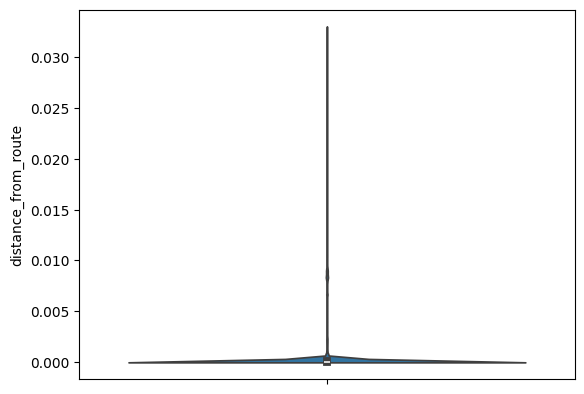

In [6]:
sns.violinplot(bus_positions['distance_from_route'])

## 2.1 - Quais horários possuem maior tempo de espera no ponto de ônibus?

In [7]:
bus_positions['timestamp_hour'] = bus_positions.timestamp_gps.dt.hour

In [8]:
traveling_buses = bus_positions[(bus_positions.next_stop_index != bus_positions.previous_stop_index) & (bus_positions.velocidade_instantanea > 0)]
traveling_buses['stop_distance'] = traveling_buses.swifter.apply(lambda x: stop_list.loc[x['next_stop_index'], 'shape_dist_traveled'] - stop_list.loc[x['previous_stop_index'], 'shape_dist_traveled'], axis=1)
traveling_buses  

Pandas Apply:   0%|          | 0/7140754 [00:00<?, ?it/s]

C:\Users\thlam\AppData\Local\Temp\ipykernel_24216\959434510.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traveling_buses['stop_distance'] = traveling_buses.swifter.apply(lambda x: stop_list.loc[x['next_stop_index'], 'shape_dist_traveled'] - stop_list.loc[x['previous_stop_index'], 'shape_dist_traveled'], axis=1)


,timestamp_gps,latitude,longitude,velocidade_instantanea,velocidade_estimada_10_min,id_veiculo,trip_id,datetime_partida,datetime_chegada,sentido,tempo_viagem,geometry,relative_roundtrip_distance,relative_distance,next_stop_index,previous_stop_index,distance_from_route,timestamp_hour,stop_distance
0,2023-01-21 15:30:23,-22.90116,-43.18919,21,8.3,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18919 -22.90116),0.508194,0.017065,70,69,0.000042,15,1137.20
1,2023-01-21 15:30:53,-22.90051,-43.18815,14,9.0,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18815 -22.90051),0.509991,0.020657,70,69,0.000053,15,1137.20
2,2023-01-21 15:31:23,-22.90031,-43.18695,31,9.6,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18695 -22.90031),0.512295,0.025263,70,69,0.000072,15,1137.20
3,2023-01-21 15:31:53,-22.90179,-43.18496,10,11.4,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18496 -22.90179),0.515924,0.032515,71,70,0.000014,15,534.65
4,2023-01-21 15:32:23,-22.90200,-43.18444,20,11.1,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18444 -22.902),0.516765,0.034197,71,70,0.000021,15,534.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10306442,2023-07-25 21:07:48,-22.90116,-43.17926,26,27.4,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.17926 -22.90116),0.476072,0.952802,67,66,0.000040,21,487.88
10306443,2023-07-25 21:08:18,-22.90138,-43.18009,21,26.8,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18009 -22.90138),0.477393,0.955445,67,66,0.000137,21,487.88
10306444,2023-07-25 21:08:48,-22.90224,-43.18263,38,28.7,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18263 -22.90224),0.481319,0.963303,68,67,0.000101,21,640.61
10306445,2023-07-25 21:09:18,-22.90330,-43.18600,46,28.4,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.186 -22.9033),0.486508,0.973688,68,67,0.000038,21,640.61


In [9]:
average_speed_by_hour_and_segment = traveling_buses.groupby(['timestamp_hour', 'next_stop_index']).agg({
    'velocidade_instantanea': 'mean',
    'stop_distance': 'first'
}).reset_index()
average_speed_by_hour_and_segment

,timestamp_hour,next_stop_index,velocidade_instantanea,stop_distance
0,0,1,52.889901,2935.40
1,0,2,38.453147,811.48
2,0,3,43.359281,431.40
3,0,4,55.226387,532.62
4,0,5,54.159664,370.84
...,...,...,...,...
3379,23,137,42.392617,455.99
3380,23,138,51.643678,424.05
3381,23,139,48.941532,436.35
3382,23,140,46.512411,453.71


In [10]:
average_speed_by_hour_and_segment['time_to_serve'] = average_speed_by_hour_and_segment['stop_distance'] / (average_speed_by_hour_and_segment['velocidade_instantanea'] / 3.6)
average_speed_by_hour_and_segment

,timestamp_hour,next_stop_index,velocidade_instantanea,stop_distance,time_to_serve
0,0,1,52.889901,2935.40,199.800716
1,0,2,38.453147,811.48,75.971104
2,0,3,43.359281,431.40,35.817937
3,0,4,55.226387,532.62,34.719490
4,0,5,54.159664,370.84,24.649784
...,...,...,...,...,...
3379,23,137,42.392617,455.99,38.722874
3380,23,138,51.643678,424.05,29.559862
3381,23,139,48.941532,436.35,32.096666
3382,23,140,46.512411,453.71,35.116562


In [11]:
stop_serve_time = average_speed_by_hour_and_segment.set_index(["timestamp_hour", "next_stop_index"])['time_to_serve']
stop_serve_time.sort_index(inplace=True)
stop_serve_time

timestamp_hour  next_stop_index
0               1                  199.800716
                2                   75.971104
                3                   35.817937
                4                   34.719490
                5                   24.649784
                                      ...    
23              137                 38.722874
                138                 29.559862
                139                 32.096666
                140                 35.116562
                141                149.979959
Name: time_to_serve, Length: 3384, dtype: float64

In [12]:
from tqdm import tqdm

days = bus_trips.datetime_chegada.dt.day_of_year.unique()

forward_stops = stop_list[stop_list['sentido'] == 'I'].index
backward_stops = stop_list[stop_list['sentido'] == 'V'].index

day_visits = {}
for day in tqdm(days, total=len(days)):
    trips = bus_trips[(bus_trips.datetime_chegada.dt.day_of_year == day)]
    stop_visit_times = {stop: [] for stop in stop_list.index}
    for index, trip in trips.iterrows():
        current_time = trip['datetime_partida']
        
        if trip['sentido'] == 'I':
            stops = forward_stops
        else:
            stops = backward_stops
        
        for stop in stops:
            stop_visit_times[stop].append(current_time)
            
            hour = current_time.hour
            # If this hour and stop are not in the stop_serve_time table, then the bus skips this stop
            if (hour, stop) not in stop_serve_time.index:
                continue
             
            current_time += (stop_serve_time[hour, stop] if stop > 0 else 0) * pd.Timedelta(seconds=1)
    day_visits[day] = stop_visit_times

100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [02:03<00:00,  1.72it/s]


In [13]:
day_dataframe = pd.DataFrame.from_dict(day_visits, orient='index')
day_dataframe.reset_index(inplace=True, names='day_of_year')
day_dataframe = day_dataframe.melt(
    id_vars=['day_of_year'],
    var_name='stop number',
    value_name='visit_times'
)
day_dataframe = day_dataframe.explode('visit_times', ignore_index=True)
day_dataframe = pd.merge(day_dataframe, stop_list['sentido'], left_on='stop number', right_index=True, how='left')
day_dataframe.sort_values(['day_of_year', 'stop number', 'visit_times'], inplace=True)
day_dataframe

,day_of_year,stop number,visit_times,sentido
0,1,0,2023-01-01 05:00:22.000000000,I
1,1,0,2023-01-01 05:42:45.000000000,I
2,1,0,2023-01-01 06:46:39.000000000,I
3,1,0,2023-01-01 07:04:50.000000000,I
4,1,0,2023-01-01 07:21:04.000000000,I
...,...,...,...,...
4374491,212,137,2023-07-31 00:36:46.840299586,V
4406000,212,138,2023-07-31 00:37:17.025044463,V
4437509,212,139,2023-07-31 00:37:44.447964289,V
4469018,212,140,2023-07-31 00:38:15.009229395,V


In [14]:
shifted = day_dataframe.groupby(['day_of_year', 'sentido', 'stop number'])['visit_times'].shift(1)
day_dataframe['time_since_last_visit'] = day_dataframe['visit_times'] - shifted
day_dataframe

,day_of_year,stop number,visit_times,sentido,time_since_last_visit
0,1,0,2023-01-01 05:00:22.000000000,I,NaT
1,1,0,2023-01-01 05:42:45.000000000,I,0 days 00:42:23
2,1,0,2023-01-01 06:46:39.000000000,I,0 days 01:03:54
3,1,0,2023-01-01 07:04:50.000000000,I,0 days 00:18:11
4,1,0,2023-01-01 07:21:04.000000000,I,0 days 00:16:14
...,...,...,...,...,...
4374491,212,137,2023-07-31 00:36:46.840299586,V,NaT
4406000,212,138,2023-07-31 00:37:17.025044463,V,NaT
4437509,212,139,2023-07-31 00:37:44.447964289,V,NaT
4469018,212,140,2023-07-31 00:38:15.009229395,V,NaT


In [15]:
day_dataframe['wait time (s)'] = day_dataframe['time_since_last_visit'].dt.seconds
wait_time_mean = day_dataframe['wait time (s)'].mean()
day_dataframe['wait difference from avg (s)'] = day_dataframe['wait time (s)'] - wait_time_mean
day_dataframe['hour'] = day_dataframe['visit_times'].dt.hour
day_dataframe

,day_of_year,stop number,visit_times,sentido,time_since_last_visit,wait time (s),wait difference from avg (s),hour
0,1,0,2023-01-01 05:00:22.000000000,I,NaT,NaN,NaN,5.0
1,1,0,2023-01-01 05:42:45.000000000,I,0 days 00:42:23,2543.0,1992.09805,5.0
2,1,0,2023-01-01 06:46:39.000000000,I,0 days 01:03:54,3834.0,3283.09805,6.0
3,1,0,2023-01-01 07:04:50.000000000,I,0 days 00:18:11,1091.0,540.09805,7.0
4,1,0,2023-01-01 07:21:04.000000000,I,0 days 00:16:14,974.0,423.09805,7.0
...,...,...,...,...,...,...,...,...
4374491,212,137,2023-07-31 00:36:46.840299586,V,NaT,NaN,NaN,0.0
4406000,212,138,2023-07-31 00:37:17.025044463,V,NaT,NaN,NaN,0.0
4437509,212,139,2023-07-31 00:37:44.447964289,V,NaT,NaN,NaN,0.0
4469018,212,140,2023-07-31 00:38:15.009229395,V,NaT,NaN,NaN,0.0


In [16]:
day_dataframe_normal_hours = day_dataframe[(7 <= day_dataframe['visit_times'].dt.hour) & (day_dataframe['visit_times'].dt.hour <= 20)]

In [ ]:
average_hourly_wait = day_dataframe_normal_hours.groupby(['stop number', 'hour']).agg({
    'wait time (s)': 'mean', 
    'wait difference from avg (s)': 'mean',
    'sentido': 'first'
}).reset_index()
average_hourly_wait

In [ ]:
average_wait_time_by_hour = average_hourly_wait.groupby(['sentido', 'hour']).agg({
    'wait time (s)': 'mean', 
    'wait difference from avg (s)': 'mean'
}).reset_index()
average_wait_time_by_hour['wait time (m)'] = average_wait_time_by_hour['wait time (s)'] / 60
average_wait_time_by_hour['wait difference from avg (s)'] = average_wait_time_by_hour['wait difference from avg (s)'] / 60
average_wait_time_by_hour

In [ ]:
g = sns.barplot(average_wait_time_by_hour, x='hour', hue='sentido', y='wait time (m)')
line = g.axhline(y=wait_time_mean/60, color='black', linestyle='--', zorder=-1)
g.text(x=13.6, y=wait_time_mean/60 - 0.1, s="média") 
g.set(title="Tempo médio de espera no ponto de ônibus por hora", xlabel="Hora", ylabel="Tempo de espera (minutos)")
sns.move_legend(g, 'upper left', labels=['ida', 'volta'])

In [ ]:
g = sns.barplot(average_wait_time_by_hour, x='hour', hue='sentido', y='wait difference from avg (s)')
g.axhline(y=0, color='black', linestyle='--', zorder=-1)
g.text(x=13.65, y=-0.03, s=f"média={wait_time_mean/60:.2f} min") 
g.set(title="Variação em relação à média do tempo de espera no ponto de ônibus por hora", xlabel="Hora", ylabel="Variação do tempo de espera (minutos)")
sns.move_legend(g, 'upper left', labels=['ida', 'volta'])

In [ ]:
g = sns.lineplot(average_wait_time_by_hour, x='hour', hue='sentido', y='wait time (m)')
g.set(title="Tempo médio de espera no ponto de ônibus por hora", xlabel="Hora", ylabel="Tempo de espera (minutos)", xticks=average_wait_time_by_hour.hour.unique())
g.axhline(y=wait_time_mean/60, color='black', linestyle='--', zorder=-1)
g.text(x=20.7, y=wait_time_mean/60 - 0.04, s="média") 
sns.move_legend(g, 'upper left', labels=['ida', 'volta'])

## 2.2	Alguns motoristas dirigem significativamente mais rápido ou devagar que outros?

In [ ]:
bus_positions_normal_hours = bus_positions[(7 <= bus_positions['timestamp_gps'].dt.hour) & (bus_positions['timestamp_gps'].dt.hour <= 20)]
daily_hourly_speed_average = bus_positions_normal_hours.groupby([bus_positions_normal_hours.timestamp_gps.dt.day_of_week, bus_positions_normal_hours.timestamp_gps.dt.hour])['velocidade_instantanea'].agg(velocidade_média_momento='mean')
daily_hourly_speed_average

In [ ]:
trip_average_speed = bus_positions_normal_hours.groupby(['trip_id'])['velocidade_instantanea'].agg(velocidade_média='mean')
trip_average_speed

In [ ]:
trips_with_average_speed = pd.merge(bus_trips, trip_average_speed, left_on='trip_id', right_index=True)
trips_with_average_speed

In [ ]:
trips_with_average_speed['datetime_meio'] = trips_with_average_speed['datetime_partida'] + (trips_with_average_speed['datetime_chegada'] - trips_with_average_speed['datetime_partida']) / 2
trips_with_average_speed

In [ ]:
trips_with_average_speed['dia'] = trips_with_average_speed['datetime_meio'].dt.day_of_week
trips_with_average_speed['hora'] = trips_with_average_speed['datetime_meio'].dt.hour
trips_with_average_speed

In [ ]:
trip_speed_comparison = pd.merge(trips_with_average_speed, daily_hourly_speed_average, left_on=['dia', 'hora'], right_index=True)[['trip_id', 'datetime_partida', 'velocidade_média', 'velocidade_média_momento']]
trip_speed_comparison

In [ ]:
trip_speed_comparison['diferença de velocidade'] = trip_speed_comparison['velocidade_média'] - trip_speed_comparison['velocidade_média_momento']
trip_speed_comparison

In [ ]:
g = sns.histplot(trip_speed_comparison['diferença de velocidade'], bins=51)
g.set(title="Número de viagens pela diferença de velocidade em relação à média", xlabel="Diferença de velocidade (km/h)", ylabel="Número de viagens")

In [ ]:
g = sns.violinplot(trip_speed_comparison['diferença de velocidade'])
g.set(title="Distribuição da diferença de velocidade em relação à média", ylabel="Diferença de velocidade (km/h)")

In [ ]:
stats = {
    'Média': trip_speed_comparison['diferença de velocidade'].mean(),
    'Desvio Padrão': trip_speed_comparison['diferença de velocidade'].std(),
    'Mínimo': trip_speed_comparison['diferença de velocidade'].min(),
    'Máximo': trip_speed_comparison['diferença de velocidade'].max()
}
stat_df = pd.DataFrame.from_dict(stats, orient='index', columns=['Valor']).reset_index(names="Estatística").set_index(['Estatística'], drop=True)
stat_df

## 2.3 - O tempo de espera nos pontos de ônibus é uniforme na linha 309?

In [17]:
stop_number_waits = day_dataframe_normal_hours[['visit_times', 'stop number', 'hour', 'sentido', 'wait time (s)']]
stop_number_waits['wait time (min)'] = stop_number_waits['wait time (s)'] / 60
stop_number_waits

C:\Users\thlam\AppData\Local\Temp\ipykernel_24216\2086951396.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stop_number_waits['wait time (min)'] = stop_number_waits['wait time (s)'] / 60


,visit_times,stop number,hour,sentido,wait time (s),wait time (min)
3,2023-01-01 07:04:50.000000000,0,7.0,I,1091.0,18.183333
4,2023-01-01 07:21:04.000000000,0,7.0,I,974.0,16.233333
5,2023-01-01 08:02:25.000000000,0,8.0,I,2481.0,41.350000
6,2023-01-01 09:05:06.000000000,0,9.0,I,3761.0,62.683333
7,2023-01-01 09:11:43.000000000,0,9.0,I,397.0,6.616667
...,...,...,...,...,...,...
4500518,2023-07-30 20:12:00.688827274,141,20.0,V,630.0,10.500000
4500519,2023-07-30 20:25:44.956084856,141,20.0,V,824.0,13.733333
4500520,2023-07-30 20:37:45.549811711,141,20.0,V,720.0,12.000000
4500521,2023-07-30 20:49:59.254348975,141,20.0,V,733.0,12.216667


In [ ]:
from matplotlib import pyplot as plt
import math

for slider_value in tqdm(range(70, 191), total=191-70):
    slider_value /= 10
    
    slider_hour = math.floor(slider_value)
    slider_minutes = math.floor((slider_value - slider_hour) * 60)
    slider_time = pd.Timestamp(hour=slider_hour, minute=slider_minutes, year=2023, month=1, day=1)
    
    range_start = (slider_time - pd.Timedelta(minutes=30)).time()
    range_end = (slider_time + pd.Timedelta(minutes=30)).time()
    
    data = stop_number_waits[ \
        (stop_number_waits.visit_times.dt.time >= range_start) &
        (stop_number_waits.visit_times.dt.time <= range_end) \
    ]
    data = data.groupby(['stop number', 'sentido'])['wait time (min)'].mean().reset_index(name='wait time (minutes)')
    data.loc[data.sentido=='V', 'stop number'] -= data[data.sentido=='I']['stop number'].max()
    g = sns.lineplot(data, x='stop number', y='wait time (minutes)', hue='sentido')
    g.set(title=f"Tempo médio de espera no ponto de ônibus por paradas entre 07:00 e 20:00\n"
                f"Horário: {range_start} a {range_end}", 
          xlabel="Parada", 
          ylabel="Tempo de espera (minutos)",
          ylim=(0, 10))
    g.figure.set_size_inches(10, 5)
    sns.move_legend(g, 'upper left', labels=['ida', 'volta'])
    g.figure.savefig(f"./images/{slider_value}.png")
    plt.close()

  0%|                                                                                          | 0/121 [00:02<?, ?it/s]


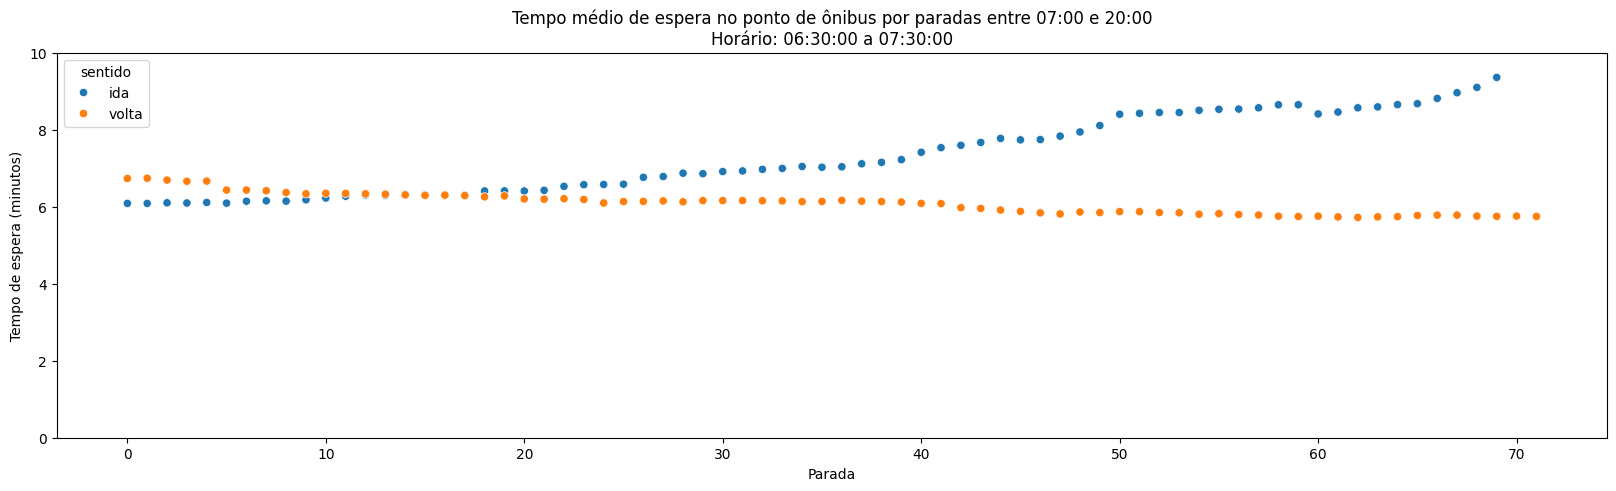

In [18]:
from matplotlib import pyplot as plt
import math

for slider_value in tqdm(range(70, 191), total=191-70):
    slider_value /= 10
    
    slider_hour = math.floor(slider_value)
    slider_minutes = math.floor((slider_value - slider_hour) * 60)
    slider_time = pd.Timestamp(hour=slider_hour, minute=slider_minutes, year=2023, month=1, day=1)
    
    range_start = (slider_time - pd.Timedelta(minutes=30)).time()
    range_end = (slider_time + pd.Timedelta(minutes=30)).time()
    
    data = stop_number_waits[ \
        (stop_number_waits.visit_times.dt.time >= range_start) &
        (stop_number_waits.visit_times.dt.time <= range_end) \
    ]
    data = data.groupby(['stop number', 'sentido'])['wait time (min)'].mean().reset_index(name='wait time (minutes)')
    data.loc[data.sentido=='V', 'stop number'] -= data[data.sentido=='V']['stop number'].min()
    g = sns.barplot(data, x='stop number', y='wait time (minutes)', hue='sentido')
    g.set(title=f"Tempo médio de espera no ponto de ônibus por paradas entre 07:00 e 20:00\n"
                f"Horário: {range_start} a {range_end}", 
          xlabel="Parada", 
          ylabel="Tempo de espera (minutos)",
          ylim=(0, 10))
    g.figure.set_size_inches(20, 5)
    sns.move_legend(g, 'upper left', labels=['ida', 'volta'])
    g.figure.savefig(f"./images/{slider_value}.png")
    plt.close()

In [ ]:
from matplotlib import pyplot as plt
import math

stats = {}

for hour in range(7, 21):
    
    slider_hour = math.floor(hour)
    slider_time = pd.Timestamp(hour=slider_hour, year=2023, month=1, day=1)
    
    range_start = (slider_time - pd.Timedelta(minutes=30)).time()
    range_end = (slider_time + pd.Timedelta(minutes=30)).time()
    
    data = stop_number_waits[ \
        (stop_number_waits.visit_times.dt.time >= range_start) &
        (stop_number_waits.visit_times.dt.time <= range_end) \
    ]
    data = data.groupby(['stop number', 'sentido'])['wait time (min)'].mean().reset_index(name='wait time (minutes)')
    data.loc[data.sentido=='V', 'stop number'] -= data[data.sentido=='V']['stop number'].min()
    
    for direction in ['I', 'V']:
        relevant_stats = {
            'Média': data[data.sentido==direction]['wait time (minutes)'].mean(),
            'Desvio Padrão': data[data.sentido==direction]['wait time (minutes)'].std(),
            'Mínimo': data[data.sentido==direction]['wait time (minutes)'].min(),
            'Máximo': data[data.sentido==direction]['wait time (minutes)'].max()
        }
        stats[(hour, 'Ida' if direction == 'I' else 'Volta')] = relevant_stats
    
stats

In [ ]:
stat_dataframe = pd.DataFrame.from_dict(stats, orient='index')
stat_dataframe.transpose()

## 2.4 - Qual a velocidade média da linha 309 durante o dia?

In [6]:
bus_position_hourly = bus_positions[['timestamp_gps', 'sentido', 'velocidade_instantanea']].copy()
bus_position_hourly['hour'] = bus_position_hourly.timestamp_gps.dt.hour

In [7]:
avg_speed_by_hour = bus_position_hourly.groupby(['hour'])['velocidade_instantanea'].agg(velocidade_instantanea='mean').reset_index()
avg_speed_by_hour

,hour,velocidade_instantanea
0,0,31.352896
1,1,34.760946
2,2,37.011831
3,3,38.324854
4,4,35.770910
5,5,33.696644
6,6,28.419269
7,7,24.080606
8,8,22.626187
9,9,21.234256


In [ ]:
g = sns.barplot(bus_position_hourly, x='hour', y='velocidade_instantanea', estimator='mean', errorbar=None)
g.set(title="Velocidade média por hora", xlabel="Hora", ylabel="Velocidade média (km/h)", xticks=avg_speed_by_hour.hour.unique())
g.figure.set_size_inches(10, 5)

In [ ]:
g = sns.lineplot(avg_speed_by_hour, x='hour', y='velocidade_instantanea')
g.set(title="Velocidade média por hora", xlabel="Hora", ylabel="Velocidade média (km/h)", xticks=avg_speed_by_hour.hour.unique())
g.figure.set_size_inches(10, 5)

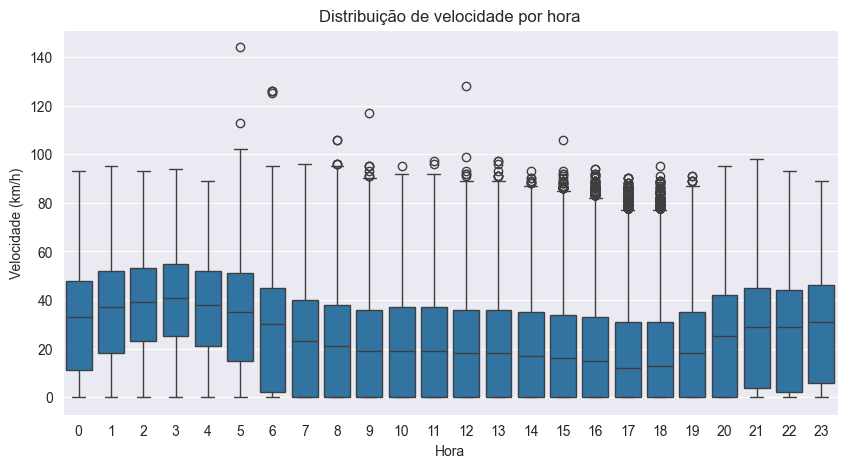

In [9]:
g = sns.boxplot(bus_position_hourly, x='hour', y='velocidade_instantanea')
g.set(title="Distribuição de velocidade por hora", xlabel="Hora", ylabel="Velocidade (km/h)", xticks=avg_speed_by_hour.hour.unique())
g.figure.set_size_inches(10, 5)